<a href="https://www.kaggle.com/code/alkaifansari000/sna-diff?scriptVersionId=236467011" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Epidemic Diffusion Simulation in Social Networks

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
import random
sns.set()

## Generate Synthetic Graphs

In [2]:
# 1. Random Graph (Erdős-Rényi)
G_random = nx.erdos_renyi_graph(n=100, p=0.1)

# 2. Small-World (Watts-Strogatz)
G_smallworld = nx.watts_strogatz_graph(n=100, k=4, p=0.2)

# 3. Scale-Free (Barabási-Albert)
G_scalefree = nx.barabasi_albert_graph(n=100, m=2)

# Store graphs in a dictionary for easy access
graphs = {
    "Random": G_random,
    "Small-World": G_smallworld,
    "Scale-Free": G_scalefree
}

##  Descriptive Analysis

In [3]:
for name, G in graphs.items():
    print(f"\n--- {name} Network ---")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    if nx.is_weighted(G):
        print("Edge weights exist.")
    else:
        print("No edge weights (unweighted).")


--- Random Network ---
Number of nodes: 100
Number of edges: 507
Average degree: 10.14
No edge weights (unweighted).

--- Small-World Network ---
Number of nodes: 100
Number of edges: 200
Average degree: 4.00
No edge weights (unweighted).

--- Scale-Free Network ---
Number of nodes: 100
Number of edges: 196
Average degree: 3.92
No edge weights (unweighted).


## Basic Visualization

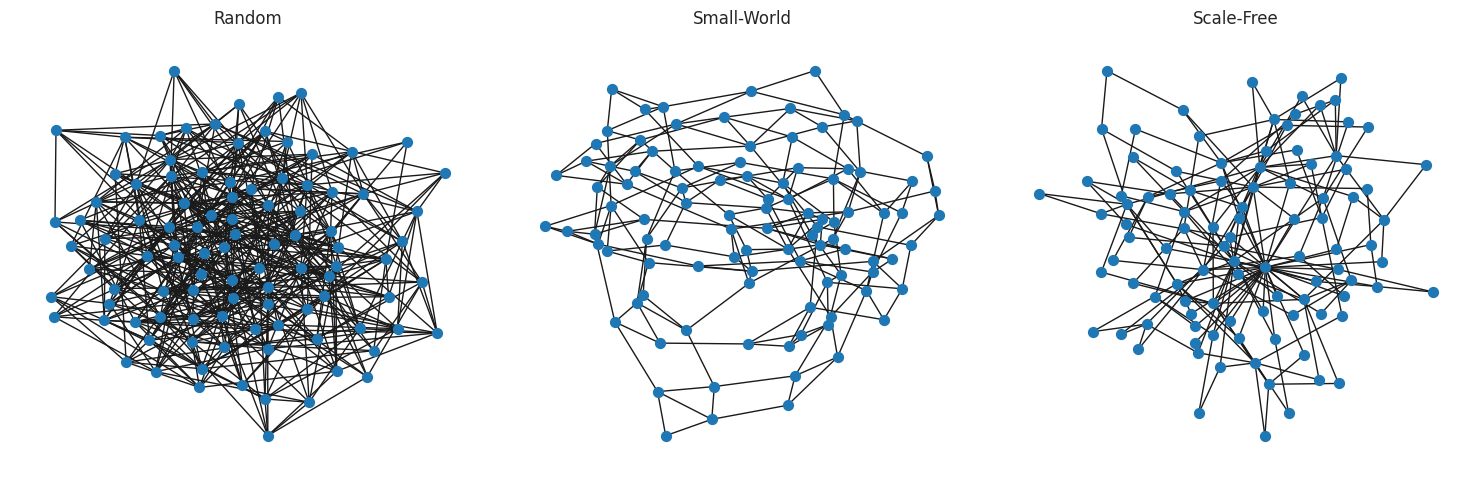

In [4]:
plt.figure(figsize=(15, 5))
for i, (name, G) in enumerate(graphs.items(), 1):
    plt.subplot(1, 3, i)
    nx.draw(G, node_size=50, with_labels=False)
    plt.title(name)
plt.tight_layout()
plt.show()

# Epidemic Model Implementation
## SI (Susceptible-Infected)
- Infected nodes spread disease to neighbors with probability infection_prob → No recovery; all remain infected.

In [5]:
def SI_model(G, initial_infected=0.1, infection_prob=0.3, steps=20):
    infected = set(random.sample(list(G.nodes()), int(initial_infected * G.number_of_nodes())))
    diffusion = [len(infected) / G.number_of_nodes()]
    
    for _ in range(steps):
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < infection_prob:
                    new_infected.add(neighbor)
        infected.update(new_infected)
        diffusion.append(len(infected) / G.number_of_nodes())
    return diffusion

## SIS (Susceptible-Infected-Susceptible)
- Spread + Recovery: Infected nodes recover with recovery_prob → Recovered nodes become susceptible again.

In [6]:
def SIS_model(G, initial_infected=0.1, infection_prob=0.3, recovery_prob=0.2, steps=30):
    infected = set(random.sample(list(G.nodes()), int(initial_infected * G.number_of_nodes())))
    diffusion = [len(infected) / G.number_of_nodes()]
    
    for _ in range(steps):
        new_infected = set()
        recovered = set()
        
        # Infection phase
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < infection_prob:
                    new_infected.add(neighbor)
        
        # Recovery phase
        for node in infected:
            if random.random() < recovery_prob:
                recovered.add(node)
                
        infected = (infected - recovered).union(new_infected)
        diffusion.append(len(infected) / G.number_of_nodes())
    return diffusion

## SIR (Susceptible-Infected-Recovered)
- Spread + Immunity: Recovered nodes gain immunity → Cannot be reinfected.

In [7]:
def SIR_model(G, initial_infected=0.1, infection_prob=0.3, recovery_prob=0.1, steps=30):
    infected = set(random.sample(list(G.nodes()), int(initial_infected * G.number_of_nodes())))
    recovered = set()
    susceptible = set(G.nodes()) - infected
    s_counts = [len(susceptible) / G.number_of_nodes()]
    i_counts = [len(infected) / G.number_of_nodes()]
    r_counts = [len(recovered) / G.number_of_nodes()]
    
    for _ in range(steps):
        new_infected = set()
        new_recovered = set()
        
        # Infection phase
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < infection_prob:
                    new_infected.add(neighbor)
        
        # Recovery phase
        for node in infected:
            if random.random() < recovery_prob:
                new_recovered.add(node)
                
        susceptible -= new_infected
        infected = (infected - new_recovered).union(new_infected)
        recovered.update(new_recovered)
        
        s_counts.append(len(susceptible) / G.number_of_nodes())
        i_counts.append(len(infected) / G.number_of_nodes())
        r_counts.append(len(recovered) / G.number_of_nodes())
    
    return s_counts, i_counts, r_counts

## SIMULATION & VISUALIZATION

In [8]:
results = defaultdict(dict)

for name, G in graphs.items():
    # Run 5 simulations and average results
    si_runs = [SI_model(G) for _ in range(5)]
    sis_runs = [SIS_model(G) for _ in range(5)]
    sir_runs = [SIR_model(G) for _ in range(5)]
    
    results[name]["SI"] = np.mean(si_runs, axis=0)
    results[name]["SIS"] = np.mean(sis_runs, axis=0)
    results[name]["SIR"] = np.mean([i for (s,i,r) in sir_runs], axis=0)  # Just infected counts

# Plot results
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

## Plot SI model comparison

(0.0, 1.1)

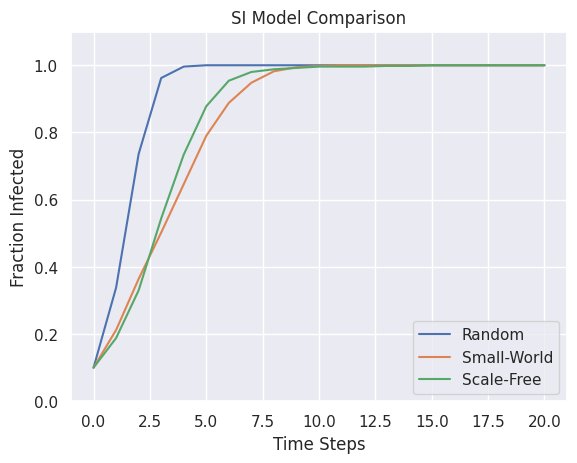

In [9]:
plt.subplot()
for name in graphs:
    sns.lineplot(data=results[name]["SI"], label=name)
plt.title("SI Model Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Fraction Infected")
plt.ylim(0, 1.1)

## Plot SIS model comparison

(0.0, 1.1)

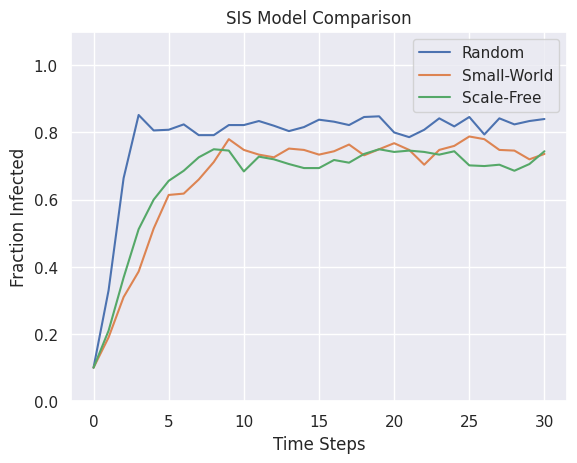

In [10]:
plt.subplot()
for name in graphs:
    sns.lineplot(data=results[name]["SIS"], label=name)
plt.title("SIS Model Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Fraction Infected")
plt.ylim(0, 1.1)

##  Plot SIR model comparison

(0.0, 1.1)

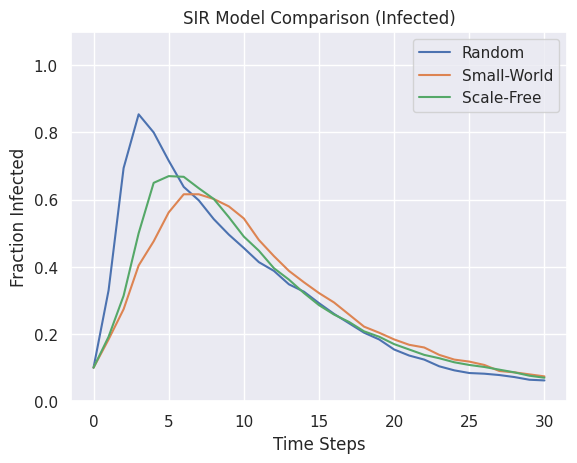

In [11]:
plt.subplot()
for name in graphs:
    sns.lineplot(data=results[name]["SIR"], label=name)
plt.title("SIR Model Comparison (Infected)")
plt.xlabel("Time Steps")
plt.ylabel("Fraction Infected")
plt.ylim(0, 1.1)

## Plot SIR components for one network

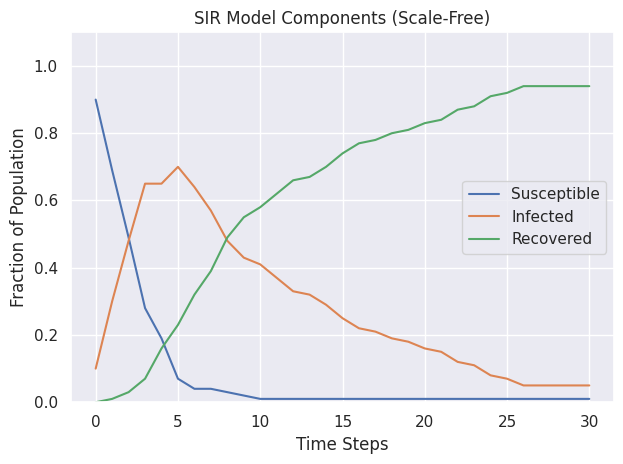

In [12]:
plt.subplot()
s, i, r = SIR_model(G_scalefree)
sns.lineplot(data=s, label="Susceptible")
sns.lineplot(data=i, label="Infected")
sns.lineplot(data=r, label="Recovered")
plt.title("SIR Model Components (Scale-Free)")
plt.xlabel("Time Steps")
plt.ylabel("Fraction of Population")
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()